<a href="https://colab.research.google.com/github/caroline1103/DQN_Project/blob/main/src/DQN_on_CARTPOLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**#DQN ON CARTPOLE**

#1. Set up

##Installations

In [2]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



##Packages



In [3]:
from collections import namedtuple, deque #to construct transitions and replay memory
from itertools import count 
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython import display #this is create animation
plt.ion()

import gym #environment to play the games


import torch
import torch.nn as nn #constructing neural network
import torch.optim as optim #optimizing
import torch.nn.functional as F

#For the videogame animation at the end
import os
import sys
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame
pygame.init()
import matplotlib.animation as animation




#2. Transitions and their storage in a replay memory


At the beggining, we want to let the computer explore freely the environment by making mistakes and seeing in what situations it gets rewarded. However, when it has had enough experiences, we also want it to start learning from what happened.

For this purpose, we store those events as transitions between two states.

In this example, we learn randomly from transitions by giving them all the same importance. However, the batches could be created differently.

Here, we train **off-policy**, because at each update we use any transition in the replay memeort, regardless of how the agent was choosing to explore the environment when the data was obtained.

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

We create a replay memory where we will store all the transitions up to a certain capacity (then we will overwrite over the oldest ones).

In [5]:
def replay_memory(capacity = 20000):
  return deque([],maxlen = capacity)

In [6]:
def add_to_memory(memory, transition):
  memory.append(transition[:])

We will want to get a random batch of memory to learn from later one and we'll use this function:

In [7]:
def meomry_batch(memory, batch_size = 128):
  return random.sample(memory, batch_size)

#Setting up the cartpole environment

First, we want to learn to play the cartpole game.

**Goal :** The goal of the game is to balance a pole on a cart which is moving left and right. We lose when the pole falls. An episode ends when the pole is more than 15 degrees from vertical or when the cart moved more than 2.4 units from the center.

**Rewards :** You score points by staying upright. The computer gains one point after each action where the pole stays upright.

**Observations:** We observe a vector of 4 parameters: the position of the cart, the velocity of the cart, the angle of the pole, and the rotation rate of the pole.

**Actions:** We can only take two actions: moving the cart right or moving it left.


In [8]:
RANDOM_SEED = 2
torch.manual_seed(RANDOM_SEED)

env = gym.make('CartPole-v1', new_step_api=True)
env.reset(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [9]:
print("Action Space: {}".format(env.action_space))

print("State space: {}".format(env.observation_space)) #[position of cart, velocity of cart, angle of pole, rotation rate of pole]

Action Space: Discrete(2)
State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


When we **take an action** in the environment, we **get back four informations**: 
* The new state of the environment after the action
* The reward we got
* If the game was terminated (we lost) or truncated (the cart went out of the frame)
* Additional informations.

In [10]:
env.step(1) #next_state, reward, terminated, truncated , info

(array([-0.02424181,  0.17450671,  0.03060641, -0.32341394], dtype=float32),
 1.0,
 False,
 False,
 {})


As seen earlier, we observe the environment of cartpole with **4 informations** and we can take **2 actions**:


In [11]:
state = env.reset()

n_observations = len(state) #for cartpole it's 4
n_actions = env.action_space.n #for carpole it's 2


#DQN, the action-value function Q

In summary, the goal of our algorithm is to find the optimal action that the agent should take at each step. 

This is when the action value function $Q*(s,a)$ comes in. It returns the maximum expected return achievable from taking the action $a$ after observing a state $s$.

We define the action value function as below with the **Bellman equation**:

$Q*(s,a) = r + \gamma max Q*(s',a')$ ,

with $r$ the reward in we get from taking action $a$ in state $s$, $Q*(s',a')$ is the expected future return we can get from the next state and $\gamma$ is the discount factor (as we would rather be rewarded sooner than later).

But in reality, we don't know $Q*$ and we need to approximate it. To this purpose we use a neural network which we define as follows(same as implemented on [the pytorch website](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training)):

In [12]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

#Selecting an action

An import step is to actually select an action for the computer to execute. From the DQN we defined above, this should be pretty easy.

However, we need to consider that at the beggining of the training, the computer doesn't know anything: it has no memories.

Furthermore, we want it to keep exploring other possibilites and avoid it taking always the same decisions which could return only a small reward (this cannot happen with carpole as the actions and reward are particularly limited but it will be the case in more complex games).

To avoid this issue, we take an $ϵ$ between 0 and 1 such that the agent takes a random action $ϵ$% of the time, and takes an action which maximes $Q*(s,a)$  the rest of the time. 

We will see later on that we define \epsilon such that it starts at one (the computer only explores new things at the beginning as it has no memories) and slowly and linearly decreases to a $\epsilon_{minimum}$ which is greater than 0. As time passes, the computer uses more and more its memory to chose its actions, but still explores a little as to possibly further improve its score.


In [13]:
def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    steps_done += 1
    if sample > eps_threshold: #we choose an action from what we learned
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
            #this returns the index (action) which allows to get maximum rewards
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long) #we choose a random action



#Generating a plot of progress

I kept the function from the pytorch tutorial as it allows for a quick overview of the progress of the computer.

The plot duration is the number of actions the computer was able to take before losing. 
In cartpole, there is basically no delays so it's also the number of actions the computer was able to take without losing.

In [14]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    #at the end
    if show_result: 
        plt.title('Result')

    #during
    else:
        plt.clf()
        plt.title('Training...')
        
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # After we went trough 100 episodes, we start ploting the average duration
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)

#Defining our DQN networks

One thing we didn't mention yet is that we are going to need two networks. Reinforcement learning tends to be quite unstable and can diverge in some cases. Some reasons might be that one action can have a huge impact on the learning curve or that there exists correlations between past and present states.

We can call them the **policy network** and the **target network**.

When we want to optimize our model, we need to perform a gradient descent. In this situation, we use the policy network to estimate $Q_{predicted}$ for each actions. We want to compare those predicted values to the ones we want, let's call them $Q_{targeted}$ with a loss function (the Huber loss function)

Basically, we are going to update the policy network at every step during the gradient descent, and we will do a soft update at a rate to be determine on the target network with the policy network weights.

(Another thing we could do is to update the weights only each $x$ steps.)


In [15]:
policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

#A few parameters to define

We need to define **a few parameters** before we start training our algorithm:

* As mentionned in the DQN function, $\gamma$ is the **discount factor** so that futur reward are less meaningful than direct rewards.

* As mentionned in the select_action function, we need **epsilon** to slowly decrease at **rate $\epsilon_{decay}$** from $\epsilon_{maximum}$ to $\epsilon_{minimum}$. The higher $\epsilon_{decay}$ is the lower the decay will be when we define $\epsilon$ as we will see later on.

* We also need to define at which **rate $τ$ we upadte the weights of the target network**. 

* The **Adam optimizer** and its **learning rate** LR. This optimizer is prefered in the litterature to the classical stochastic gradient descent as it's supposed to be more efficient and particularly adapted to these types of problems.

In [16]:

GAMMA = 0.99 # Discount factor

E_max = 0.9 # Starting epsilon
E_min = 0.05 # Ending epsilon
E_decay = 1000 # Rate of decrease

TAU = 0.005 # Rate at which we want to update the weights from the policy to the target nn

LR = 1e-4 # Learning rate of the AdamW optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)


#Optimizing the model

Once we have enough memory to get a random sample out of them, we start the optimization by creating a memory batch of transitions.

For all state and action, we compute their Q-function values through the policy network and then we compute the expected future rewards. We then compare the expected future rewards with the actual rewards we got from taking an action and we compute the Huber loss.

If the state is terminal, we set the reward to be 0 by default.

We then use the Huber loss in our backward propagation as to update our weights.


In [21]:
def optimize_model(BATCH_SIZE = 128):
    if len(memory) < BATCH_SIZE:
        return

    transitions = meomry_batch(memory, BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    #Non final states are states which do not lead to the game stoping

    #We get all those transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), dtype=torch.bool)
    #And all of those states
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    
    with torch.no_grad():
        #For the non final states, we find the actions we should take through our target nn
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # We apply the Bellman equation to get the expected rewards at each states
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss between what we expected the reward to be for an action and what the reward actually was
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model with backward propagation
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set to 600 if a GPU is available, otherwise 50 
episodes are scheduled so training does not take too long. However, 50 
episodes is insufficient for to observe good performance on cartpole.
You should see the model constantly achieve 500 steps within 600 training 
episodes. Training RL agents can be a noisy process, so restarting training
can produce better results if convergence is not observed.




#Training

##Setting up a few variables before the main training loop

In [23]:
memory = replay_memory(10000) #creating the replay memory of size 10000

steps_done = 0 #setting steps at 0 at beginning

episode_durations = [] #Where we store the episodes durations for the plots

num_episodes = 600 #number of games we want to play

##The main training loop

Complete


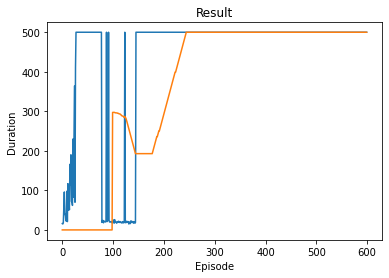

In [24]:
#For the number of games we planned to train 
for i_episode in range(num_episodes):

    # We initialize the state of the environment
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    #In each game
    for t in count():

        #We update epsilon as we defined previously
        eps_threshold = E_min + (E_max - E_min) * math.exp(-1. * steps_done / E_decay)

        #We select an action from the state and the current epsilon
        #It's either a random action or one from our DQN
        action = select_action(state, eps_threshold)

        #We do the action we chose
        observation, reward, terminated, truncated, info = env.step(action.item())

        #We get a reward
        reward = torch.tensor([reward])

        #We see if we lost
        done = terminated or truncated

        #If we lost, there is no next state but we still add it to the memory
        if terminated:
            next_state = None

        #If we didin't lose we get the new state we are in
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        #Either way, we store the transition in our memory
        add_to_memory(memory, (state, action, reward, next_state, done))

        #And our new state is now our present state
        state = next_state

        #We optimize the weights of our model on the policy network
        optimize_model()

        #And we do a soft update on the ones of the target network
        #With the ones from our policy network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

        target_net.load_state_dict(target_net_state_dict)

        #If we lost 
        if done:
            #We plot the duration of the game
            episode_durations.append(t + 1)
            plot_durations()
            break

#After we completed all the training games, we show the complete durations plot
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

#Testitng and displaying the game played

## Before training

For illustration purpose, it's nice to visualize our game.

Here, we plot how the computer plays before ot was trained, meaning it's taking random actions.

We just create an array which stores RGB images of the game until it's over. The computer takes an action and updates it's current state until the game is over.

Then we can animate all those images but putting them one after another.

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


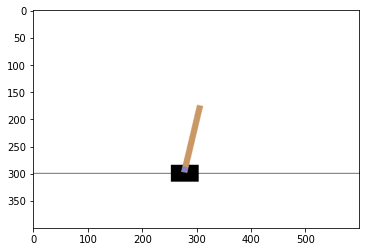

In [ ]:
fig = plt.figure()
observation = env.reset()

ims =[]
done = False
while not done:   
    im = plt.imshow(env.render(mode = 'rgb_array'), animated=True)
    ims.append([im])

    action = env.action_space.sample()
    new_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    observation = new_observation
ims.append([plt.imshow(env.render(mode = 'rgb_array'), animated=True)])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=100)

ani.save('Cartpole_before_training.mp4')

plt.show()

##After Training

We do the same thing except we don't take random actions we take an action from the policy network.

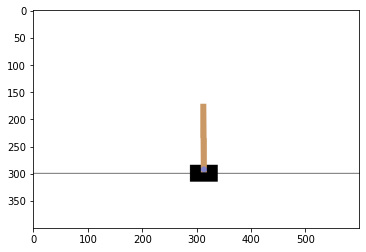

In [ ]:
fig = plt.figure()
state = env.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

ims =[]
done = False
while not done:   
    im = plt.imshow(env.render(mode = 'rgb_array'), animated=True)
    ims.append([im])

    #By setting epsilon to be 0 we are sure to never take a random action
    action = select_action(state,0)
    new_state, reward, terminated, truncated, info = env.step(action.item())
    state = new_state
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    done = terminated or truncated
ims.append([plt.imshow(env.render(mode = 'rgb_array'), animated=True)])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=100)

ani.save('Cartpole_after_training.mp4')

plt.show()